In [1]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 

import gpytorch
from gpytorch.kernels import ScaleKernel, MaternKernel, RBFKernel
from gpytorch.priors import GammaPrior
from gpytorch.likelihoods import GaussianLikelihood
import torch
import gc

gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
# Set device and global dtype
device = "cuda:0"
global_dtype = torch.float32

# Ensure reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Add project source path
notebook_dir = os.getcwd()
src_path = os.path.abspath(os.path.join(notebook_dir, '../code'))
if src_path not in sys.path:
    sys.path.append(src_path)

# Import custom modules
from gps import CholeskyGaussianProcess, IterativeGaussianProcess
from util import train, eval, plot_gpr_results, fetch_uci_dataset, memory_dump
from plotting import plot_gp_simple, plot_gp_sample, plot_gp_simple_regions

# Enable autoreloading of modules
%load_ext autoreload
%autoreload 2

In [6]:
train_x, train_y, test_x, test_y = fetch_uci_dataset('elevators',r"C:\Users\fredw\chris\Research\softki\data\uci_datasets\uci_datasets\elevators\data.csv",train_frac=4/9,val_frac=4/9)
train_x = train_x.to(device)
train_y = train_y.to(device)
test_x = test_x.to(device)

SIZE (16599, 19)
Dataset loaded


100%|██████████| 10/10 [00:00<00:00, 31.28it/s]


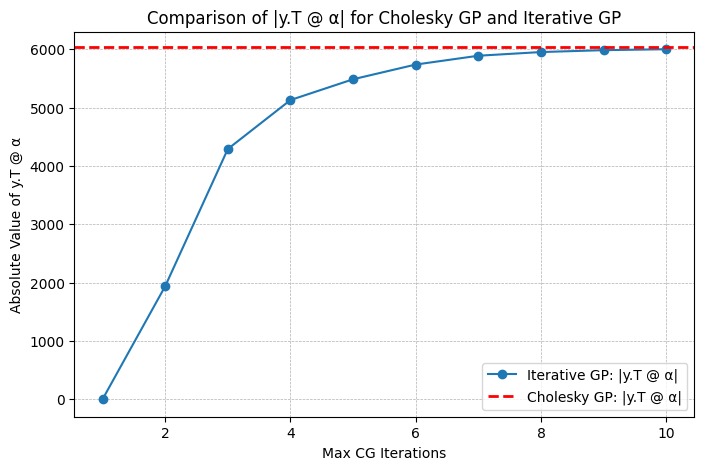

In [7]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm 

# Cholesky-based GP
base_kernel = MaternKernel(ard_num_dims=train_x.shape[-1], lengthscale_prior=GammaPrior(3.0, 6.0), nu=1.5)
kernel = ScaleKernel(base_kernel, outputscale_prior=GammaPrior(2.0, 0.15)).to(device)

gpr = CholeskyGaussianProcess(kernel=kernel, dtype=global_dtype, noise=0.4, device=device)
gpr.fit(train_x, train_y)
chol_mean, GP_covariance = gpr.predict(test_x)

# Compute absolute value of y.T @ alpha for Cholesky GP
alpha_chol = gpr.alpha  # Extract Cholesky GP alpha
chol_value = torch.abs(train_y.T @ alpha_chol).item()
del gpr, kernel, base_kernel

# Define range of max CG iterations to test
cg_max_iter_values = list(range(1, 11))
igp_values = []

# Loop over different values of cg_max_iter
for cg_max_iter in tqdm(cg_max_iter_values):
    # Reinitialize the iterative GP model with updated cg_max_iter
    base_kernel = MaternKernel(ard_num_dims=train_x.shape[-1], lengthscale_prior=GammaPrior(3.0, 6.0), nu=1.5)
    kernel = ScaleKernel(base_kernel, outputscale_prior=GammaPrior(2.0, 0.15)).to(device)

    igp = IterativeGaussianProcess(
        kernel=kernel,
        noise=0.4,
        dtype=global_dtype,
        device=device,
        cg_tol=1e-3,
        cg_max_iter=cg_max_iter,
        warm_start=False,
        num_probes=0,
        preconditioner="identity",
        trace_backend="Hutch",
        verbose=False,
        track_iterations=True,
        pred_lanczos_rank=train_x.shape[0],
        compute_covariance=False
    )

    # Fit and predict using the iterative GP model
    igp.fit(train_x, train_y)  # Extract alpha
    igp_value = torch.abs(train_y.T @ igp.alpha).item()
    igp_values.append(igp_value)

    # Delete the model and clear GPU memory
    del igp, kernel, base_kernel
    torch.cuda.empty_cache()

# Convert results to NumPy for plotting
cg_max_iter_values = np.array(cg_max_iter_values)
igp_values = np.array(igp_values)


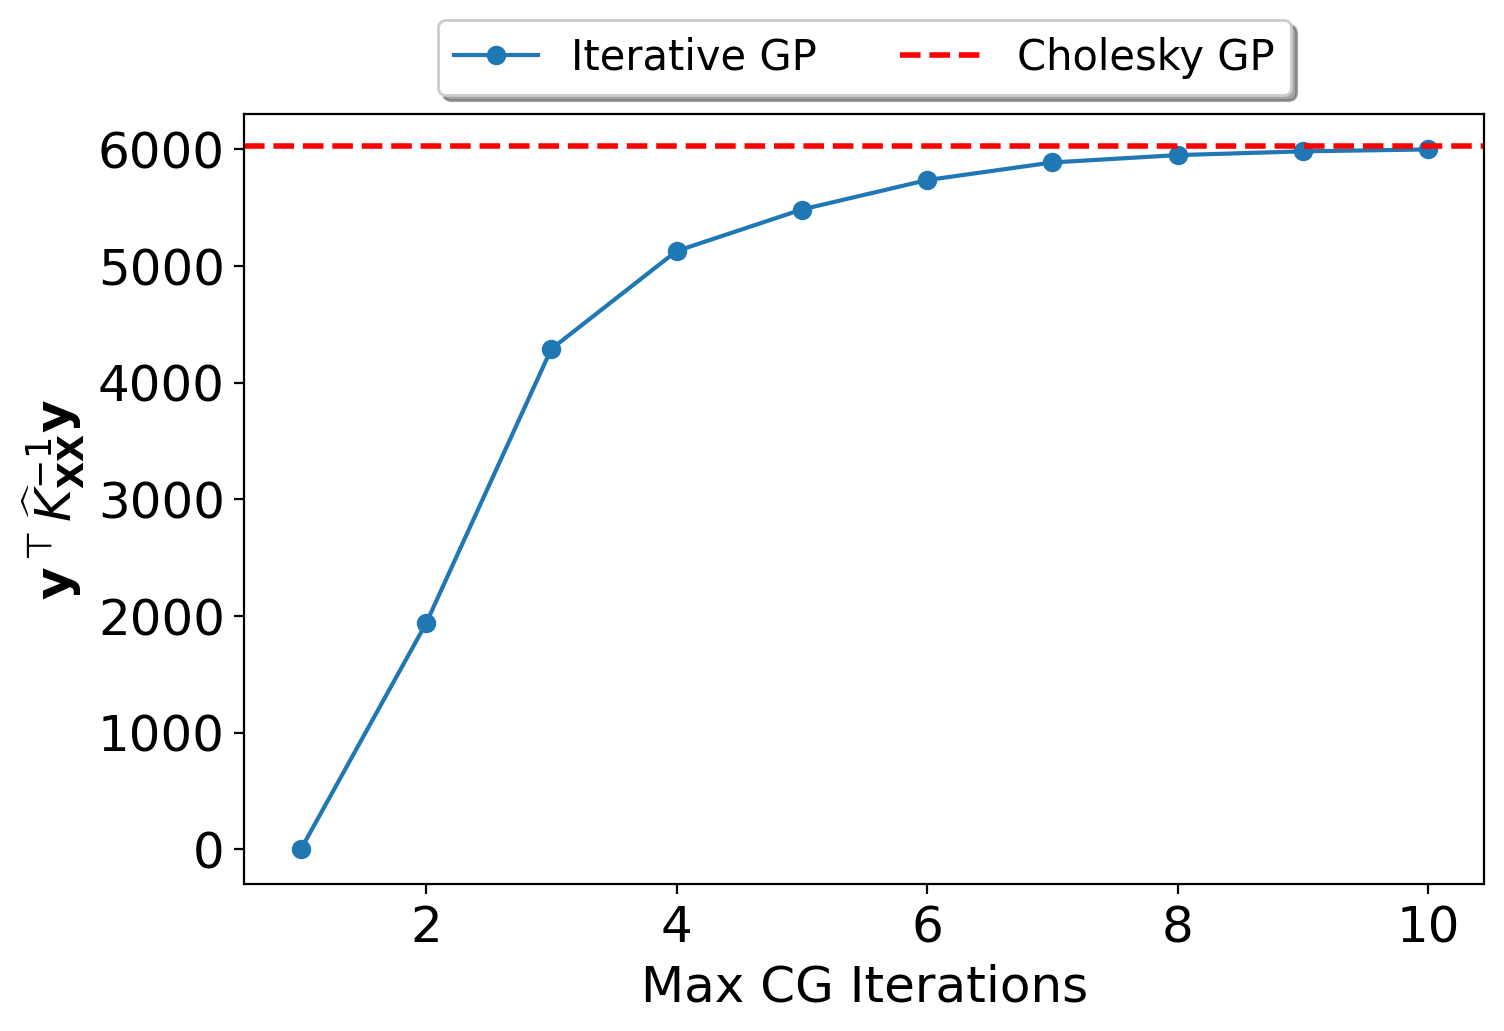

In [17]:
# Create the plot
plt.figure(figsize=(8, 5), dpi=200)
plt.plot(cg_max_iter_values, igp_values, marker='o', linestyle='-', label="Iterative GP")
plt.axhline(y=chol_value, color='r', linestyle='--', label="Cholesky GP", linewidth=2)

# Labels and title with LaTeX formatting
plt.xlabel("Max CG Iterations", fontsize=18)
plt.ylabel(r"$\mathbf{y}^\top\widehat{K}_{\mathbf{X}\mathbf{X}}^{-1}\mathbf{y}$", fontsize=18)
# plt.title("Comparison of Cholesky GP and Iterative GP", fontsize=14)

# Adjust legend position above the plot
plt.legend(loc="upper center",ncol=2, bbox_to_anchor=(0.5, 1.15), fancybox=True,shadow=True, framealpha=1, fontsize=15)

# Increase axis tick mark size
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Show the plot
plt.show()